# Frac Production Analysis

This is a continuation of the Frac Production Data Cleaning notebook.

Here I will explore and analyze the data to identify features to use for modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import re
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.stats import shapiro, mannwhitneyu, kruskal
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LinearRegression

## Importing Data

In [2]:
# Read in the cleaned colorado data
cofrac = pd.read_csv('fracwells_co.csv', index_col=0)
cofrac.head()

,WellName,WellNumber,OperatorAlias,Field,TargetFormation,TotalDepth,VerticalDepth,DrillType,UpperPerforation,LowerPerforation,...,FirstProdDate,Township,Range,TR,County,slick,gel,xlinkgel,hybrid,sandmass
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,WEP,4-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11431.00,7551.00,H,7519.0,11431.0,...,2017-04-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001097540000,WEP,1-28-11-3-64,AXIS ENERGY,DJ HORIZONTAL NIOBRARA,NIOBRARA,11715.00,7594.00,H,8151.0,11715.0,...,2013-02-01,03S,64W,03S64W,Adams,0,0,0,0.0,0.000000e+00
5001098010000,SHARP,24-3-11HC,WARD PETR,WATTENBERG,CODELL,10161.00,7774.00,H,NaN,NaN,...,2015-01-01,01S,67W,01S67W,Adams,1,0,1,1.0,2.533881e+06
5001097850000,STATE OF CO,1S-66-36-1609CH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12177.31,7576.73,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.274332e+06
5001097830000,STATE OF CO,1S-66-36-0108BH,EXTRACTION O&G,THIRD CREEK,NIOBRARA,12164.98,7511.68,H,NaN,NaN,...,2014-06-01,01S,66W,01S66W,Adams,1,0,1,1.0,3.045143e+06


In [3]:
cofrac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5220 entries, 5001097530000 to 5005071970000
Data columns (total 27 columns):
WellName                   5220 non-null object
WellNumber                 5220 non-null object
OperatorAlias              5220 non-null object
Field                      5220 non-null object
TargetFormation            5220 non-null object
TotalDepth                 5212 non-null float64
VerticalDepth              5210 non-null float64
DrillType                  5220 non-null object
UpperPerforation           4319 non-null float64
LowerPerforation           4319 non-null float64
GrossPerforatedInterval    4319 non-null float64
HorizontalLength           5218 non-null float64
TreatmentJobCount          5218 non-null float64
CumBOE                     5220 non-null float64
CumGas                     5220 non-null float64
CumOil                     5220 non-null float64
First6BOE                  5220 non-null float64
FirstProdDate              5220 non-null obje

Let's first see how many different values each column has. 

In [4]:
cofrac.nunique()

WellName                    907
WellNumber                 4480
OperatorAlias                30
Field                        15
TargetFormation               3
TotalDepth                 3442
VerticalDepth              2893
DrillType                     1
UpperPerforation           1764
LowerPerforation           3079
GrossPerforatedInterval    2599
HorizontalLength           5173
TreatmentJobCount             5
CumBOE                     5163
CumGas                     5209
CumOil                     5125
First6BOE                  5074
FirstProdDate                87
Township                     14
Range                        12
TR                           88
County                        5
slick                         2
gel                           2
xlinkgel                      2
hybrid                        2
sandmass                   3850
dtype: int64

Looks like there are 25 different operators in this data set. I will further investigate these different values, along with the distributions of the continuous variables.

The following columns are more for identification rather than to act as potential features for modeling: Well Name, Well Number, First Production Date and probably Field, as that will change from state to state.

I'll start with the categorical variables in case they need further cleaning.

### Data Cleaning
#### Field

In [5]:
cofrac.Field.value_counts()

WATTENBERG                        4390
DJ HORIZONTAL NIOBRARA             579
WILDCAT                            165
HEREFORD                            40
SEVERANCE                           10
EATON                                7
DJ HORIZONTAL CODELL                 6
SPINDLE                              5
NORTH RIVERSIDE                      4
THIRD CREEK                          4
DJ HORIZONTAL CODELL-FORT HAYS       3
RIVERSIDE                            3
NE RIVERSIDE II                      2
MASTERS                              1
GREELEY                              1
Name: Field, dtype: int64

Wow, it looks like the Wattenberg field is the most common field drilled in this data set. I might want to combine some of these fields in the future, or just use the Wattenberg field.

#### Target Formation
Next, let's take a look at the different target formations.  This will tell us the type of rock that the well is targeting and should be important in the amount of production of the well. 

In [6]:
cofrac.TargetFormation.value_counts()

NIOBRARA    4050
CODELL      1151
OTHER         19
Name: TargetFormation, dtype: int64

The majority of wells targeted the Niobrara formation or Codell formation.  According to industry professionals, the only two oil and gas producing formations are Niobrara and Codell, so the target formations listed with multiple different formations should really just be the deepest formation.  The formations from top to bottom are: Niobrara, Fort Hays, Codell, and Carlisle. I will recode these as such.


In [7]:
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: str(x))
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: 'CODELL' if re.search('CODELL|CD', x) else x)
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: 'NIOBRARA' if re.search('NIOBRARA', x) else x)
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: x if re.search('CODELL|NIOBRARA', x) else 'OTHER')
cofrac.TargetFormation.value_counts()

NIOBRARA    4050
CODELL      1151
OTHER         19
Name: TargetFormation, dtype: int64

### Location Normalization
Now, there are a number of different location information points.  In order to reduce the feature space and generalize for all of those features, I will perform clustering to group these data points into similar locations, which should help to account for the different rock formations and locations.  I will cluster based on township/range, county, field, and target formation.

In [8]:
# Pulling out location-based identifiers to cluster
loc = cofrac[['TR','County', 'Field', 'TargetFormation']]
loc = pd.get_dummies(loc)
loc.head()

,TR_01N64W,TR_01N65W,TR_01N66W,TR_01N67W,TR_01N68W,TR_01S66W,TR_01S67W,TR_01S68W,TR_02N63W,TR_02N64W,...,Field_NORTH RIVERSIDE,Field_RIVERSIDE,Field_SEVERANCE,Field_SPINDLE,Field_THIRD CREEK,Field_WATTENBERG,Field_WILDCAT,TargetFormation_CODELL,TargetFormation_NIOBRARA,TargetFormation_OTHER
APINumber,,,,,,,,,,,,,,,,,,,,,
5001097530000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5001097540000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5001098010000,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5001097850000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5001097830000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Great, now I will try different cluster numbers to determine, based on silhouette score, which clusters have the closest commonalities.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n in range(2,22,2):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(loc)
    labels = kmeans.labels_
    print('Number of Clusters: {}'.format(n))
    print(silhouette_score(loc, labels, metric='euclidean'))

Number of Clusters: 2
0.2631580379477226
Number of Clusters: 4
0.3120062262557086
Number of Clusters: 6
0.22808814232341865
Number of Clusters: 8
0.2597337656879311
Number of Clusters: 10
0.25998048619560443
Number of Clusters: 12
0.3324021490239039
Number of Clusters: 14
0.3796137923286643
Number of Clusters: 16
0.41977717309019313
Number of Clusters: 18
0.42310091073408107
Number of Clusters: 20
0.4426048663327202


I will choose 16 clusters to normalize these clusters.  Although the silhouette score continues to increase after 16 clusters, this is the last large jump of 0.03 in silhouette score.  Now, I will create these labels as locations in our data set, and I will also perform a kruskal test to make sure that there are differences in production between these variables.

In [10]:
kmeans = KMeans(n_clusters=16, random_state=42).fit(loc)
labels = kmeans.labels_
cofrac['location'] = labels
t, p = kruskal(cofrac[cofrac['location']==0]['First6BOE'],
               cofrac[cofrac['location']==1]['First6BOE'], 
               cofrac[cofrac['location']==2]['First6BOE'],
               cofrac[cofrac['location']==3]['First6BOE'],
              cofrac[cofrac['location']==4]['First6BOE'],
              cofrac[cofrac['location']==5]['First6BOE'],
              cofrac[cofrac['location']==6]['First6BOE'],
              cofrac[cofrac['location']==7]['First6BOE'],
              cofrac[cofrac['location']==8]['First6BOE'],
              cofrac[cofrac['location']==9]['First6BOE'],
              cofrac[cofrac['location']==10]['First6BOE'],
              cofrac[cofrac['location']==11]['First6BOE'],
              cofrac[cofrac['location']==12]['First6BOE'],
              cofrac[cofrac['location']==13]['First6BOE'],
              cofrac[cofrac['location']==14]['First6BOE'],
              cofrac[cofrac['location']==15]['First6BOE'])
print(p)

5.666858182759195e-124


Great! These look like they have differences between one another in terms of production.  I will check their distributions through graphing to determine if this is visually accurate.

#### Continuous Variables

Now let's check the continuous variables.

In [11]:
cofrac.describe()

,TotalDepth,VerticalDepth,UpperPerforation,LowerPerforation,GrossPerforatedInterval,HorizontalLength,TreatmentJobCount,CumBOE,CumGas,CumOil,First6BOE,slick,gel,xlinkgel,hybrid,sandmass,location
count,5212.000000,5210.000000,4319.000000,4319.000000,4319.000000,5218.000000,5218.000000,5220.000000,5.220000e+03,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000,5.218000e+03,5220.000000
mean,12878.990846,6857.418305,7386.293355,12740.042602,5353.749248,6011.867813,1.311614,155626.998276,4.177970e+05,85994.121073,56920.921839,0.864943,0.024330,0.608429,0.631609,3.787006e+06,4.371648
std,2262.604223,554.396400,634.410077,2109.403861,2034.062398,2231.362238,0.518272,84886.020930,3.149566e+05,44536.048822,29003.069779,0.341818,0.154085,0.488148,0.482414,4.267373e+06,4.609008
min,2839.000000,713.000000,248.000000,6870.000000,49.000000,29.590000,1.000000,402.000000,6.350000e+02,296.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,11310.000000,6543.500000,7095.500000,11255.000000,3962.000000,4483.465000,1.000000,95439.500000,1.799692e+05,55849.500000,37518.750000,1.000000,0.000000,0.000000,0.000000,1.826881e+06,1.000000
50%,12052.000000,6992.000000,7501.000000,11982.000000,4370.000000,4933.265000,1.000000,140872.500000,3.284300e+05,77235.500000,52869.500000,1.000000,0.000000,1.000000,1.000000,3.163582e+06,2.000000
75%,14206.000000,7235.327500,7748.000000,13944.000000,6560.000000,7377.195000,2.000000,197461.750000,5.858402e+05,107268.500000,70720.250000,1.000000,0.000000,1.000000,1.000000,4.548139e+06,7.000000
max,22086.000000,9793.000000,16864.000000,21986.000000,15982.000000,15695.510000,5.000000,677112.000000,2.716674e+06,356272.000000,236728.000000,1.000000,1.000000,1.000000,1.000000,1.681255e+08,15.000000


There is definitely a large spread in production, hopefully I can extract why this might be! 

There are still missing values in the perforation information, and a couple in total depth and vertical depth.  I will analyze these variables to determine if it is worth keeping or imputing these values before moving on. 

There are very few 0-values in this set, aside from the binary types of frac method. Let's see what these look like in more detail.

## Exploratory Data Analysis
### Production - First 6 Months BOE
First, let's take a look at the distribution of our target variable, First 6 months BOE or barrels of oil equivalencies.  This will tell us how we will need to compare the other distributions if this is normally distributed or not.

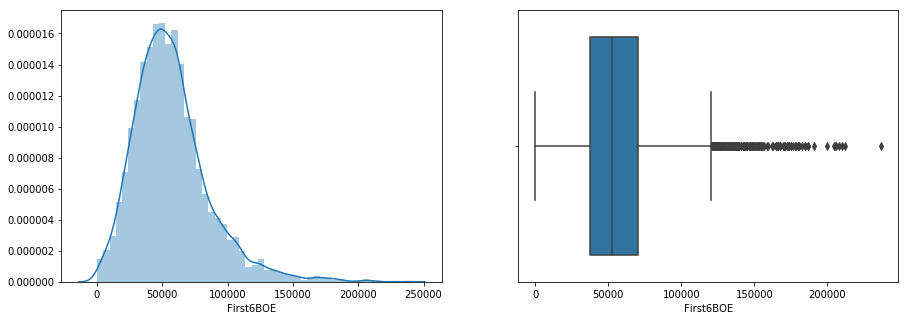

Shapiro-Wilk test for Normality:
W: 0.9342953562736511
p-value:4.091791515828466e-43


In [12]:
# Plotting the distribution of First 6 month's BOE
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(cofrac.First6BOE)
plt.subplot(122)
sns.boxplot(cofrac.First6BOE)
plt.show()

w, p = shapiro(cofrac.First6BOE)
print('Shapiro-Wilk test for Normality:\nW: {}\np-value:{}'.format(w, p))

It appears that the distribution of the first six months of production is skewed to the right with the median just above 50K BOE and a good amount of outliers above 150K BOE.  Also, according to the Shapiro-Wilk test for normality, we can reject that the distribution is approximately normally distributed.  

### Distributions
To investigate whether the columns are correlated with higher production, I will graph both the distribution of the individual column data along with its distribution relative to first 6 month's BOE.

In [13]:
# Isolating columns to examine and removing identifiers
cofrac_red = cofrac[['First6BOE', 'County', 'location', 'Field','GrossPerforatedInterval','HorizontalLength', 'LowerPerforation',
                     'TargetFormation','TotalDepth', 'TreatmentJobCount', 'TR', 'UpperPerforation', 'VerticalDepth',
                    'gel', 'sandmass','slick', 'xlinkgel', 'hybrid']]

County


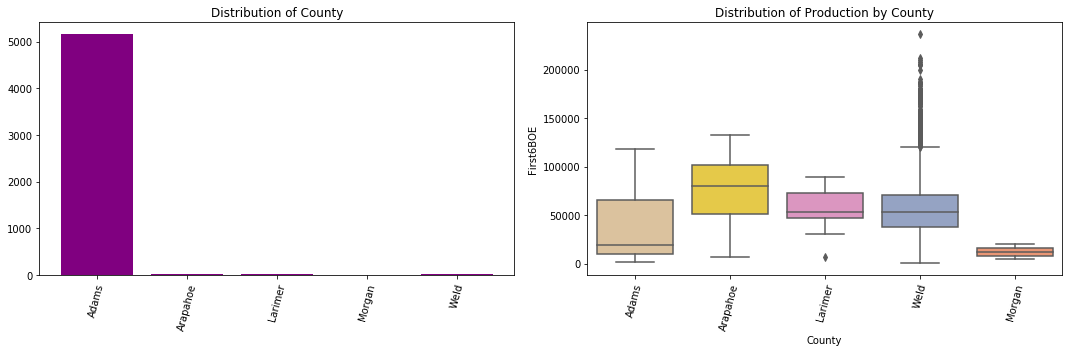

location


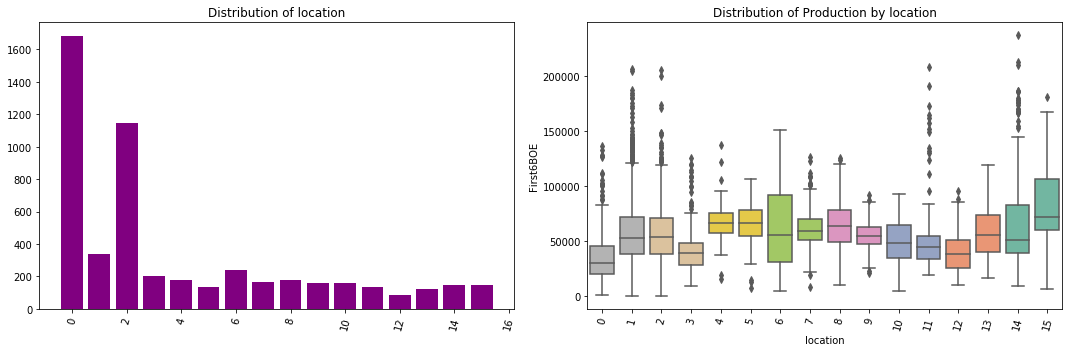

Field


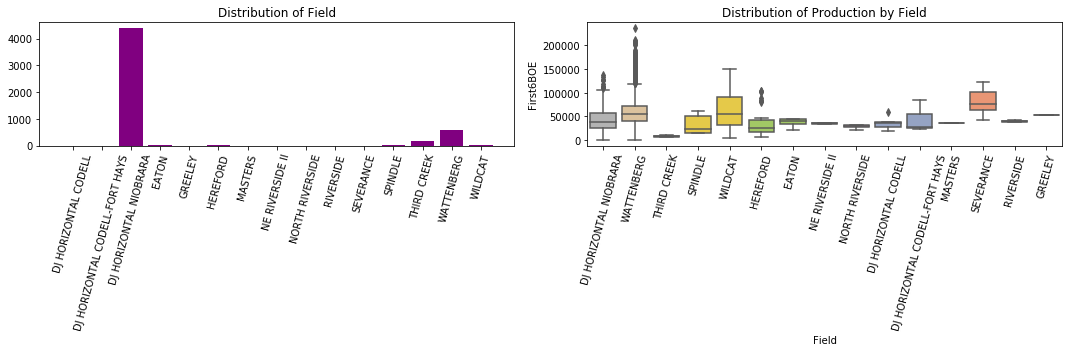

GrossPerforatedInterval


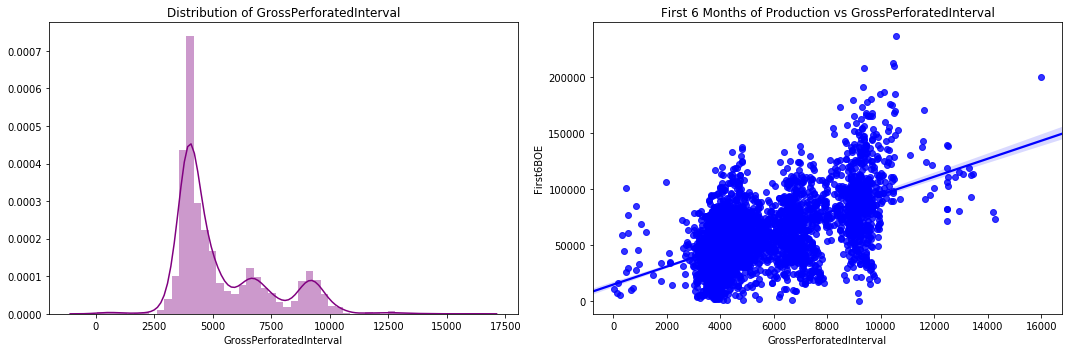

HorizontalLength


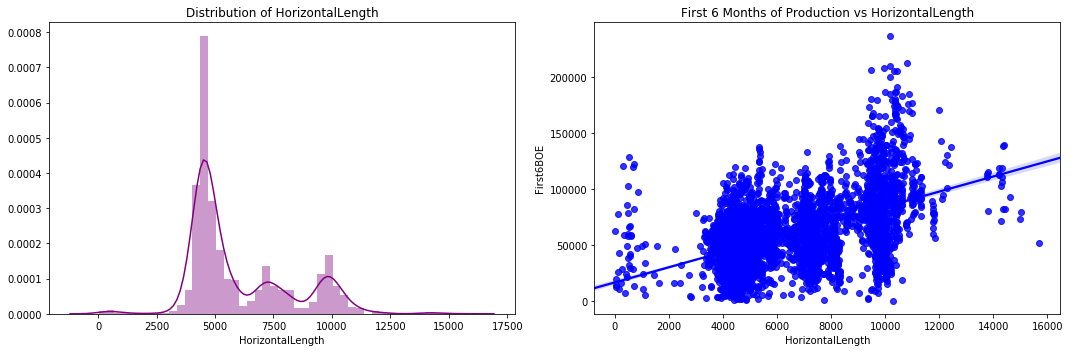

LowerPerforation


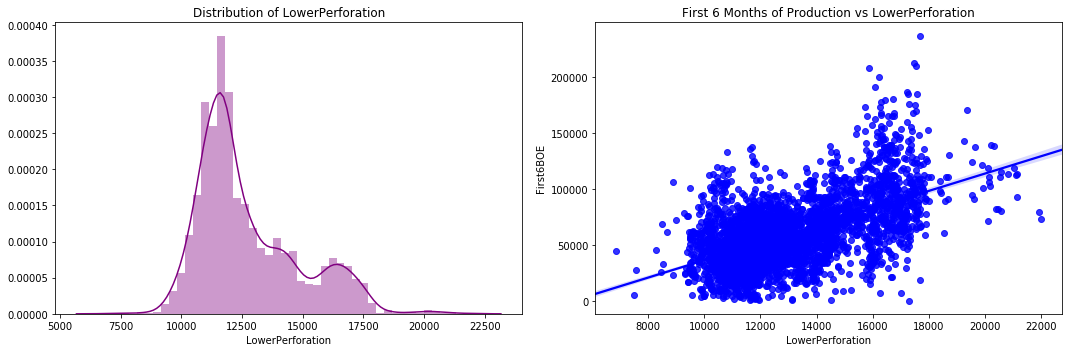

TargetFormation


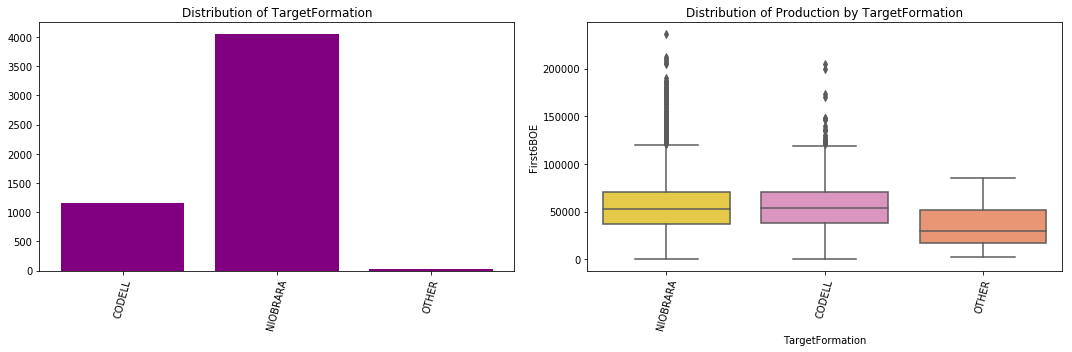

TotalDepth


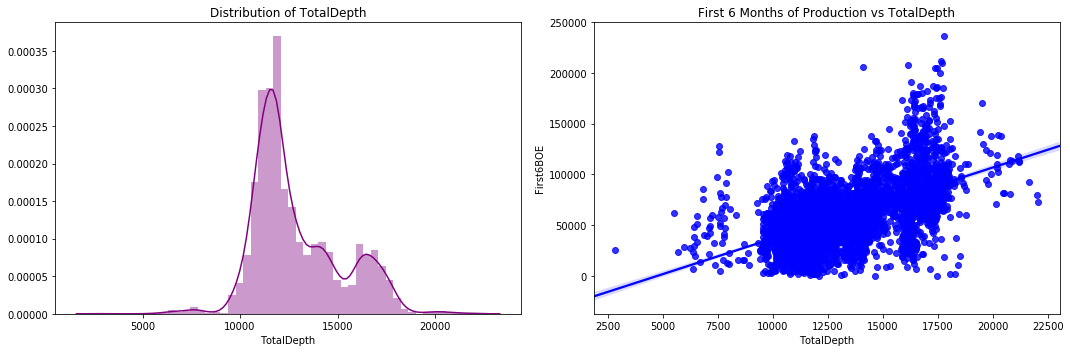

TreatmentJobCount


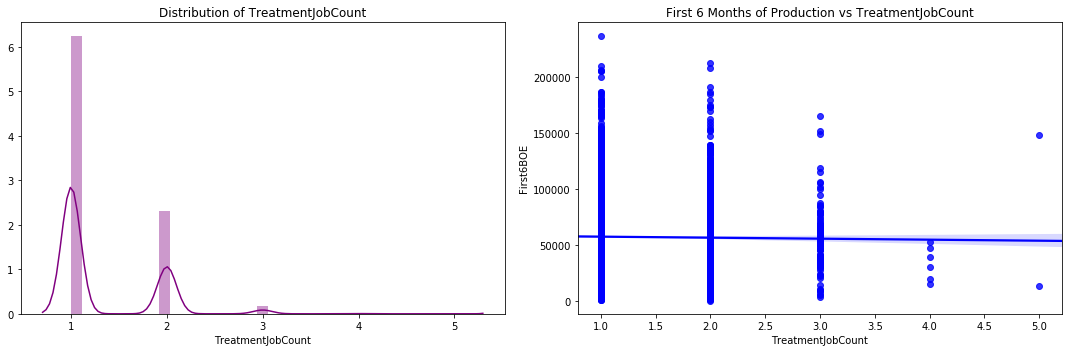

TR


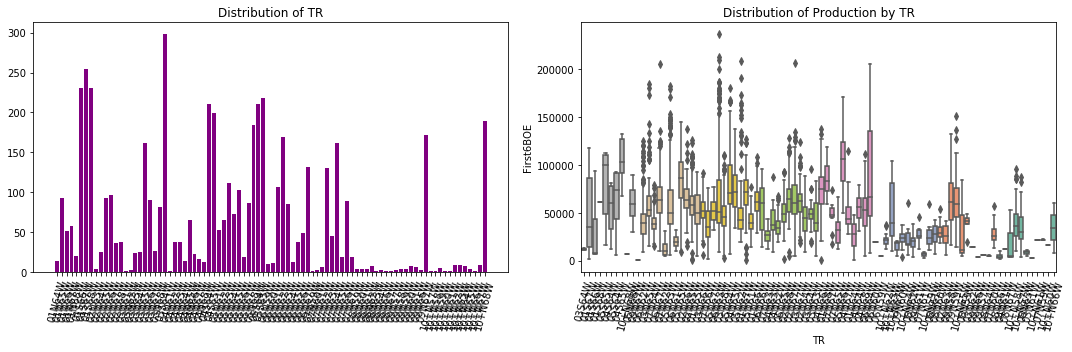

UpperPerforation


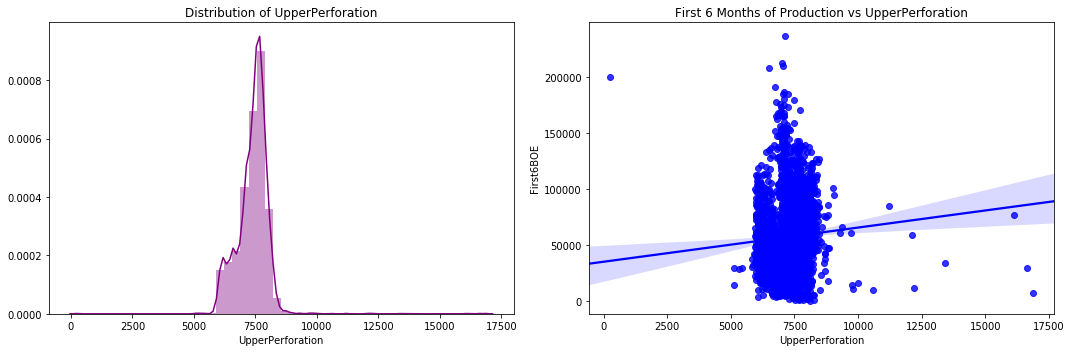

VerticalDepth


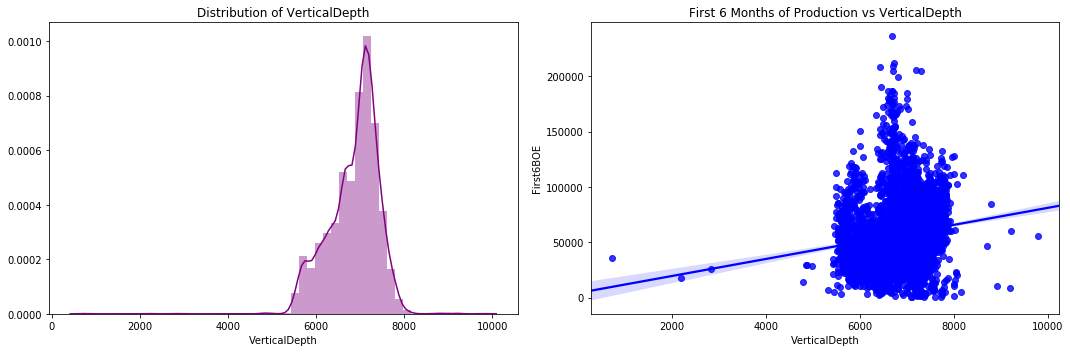

gel


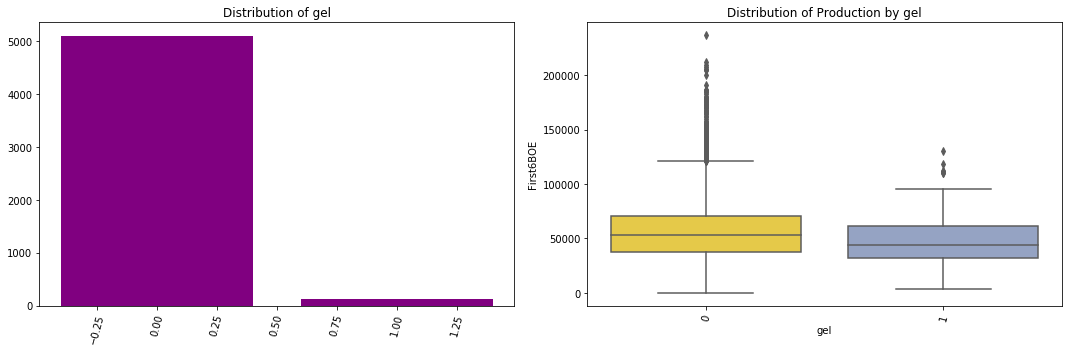

sandmass


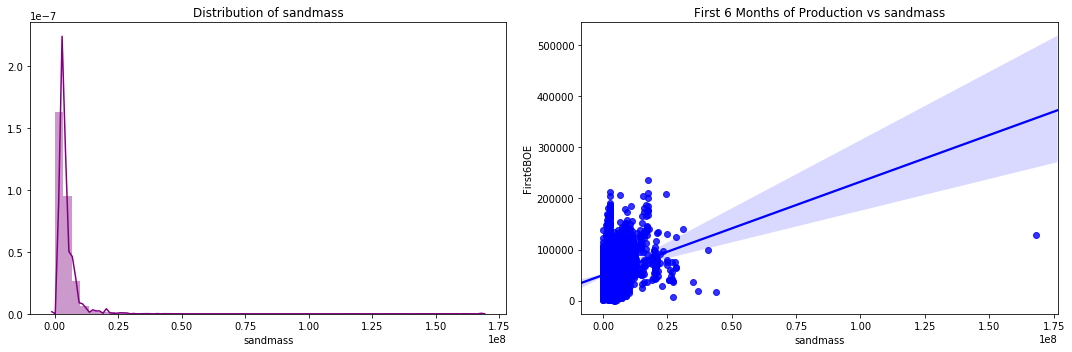

slick


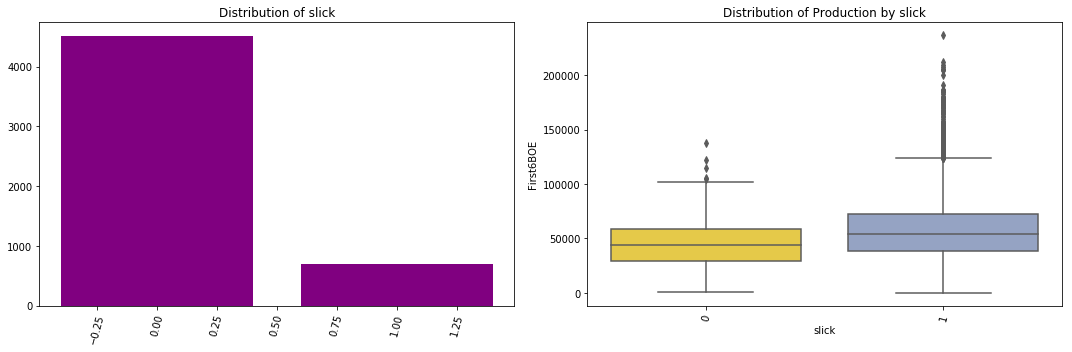

xlinkgel


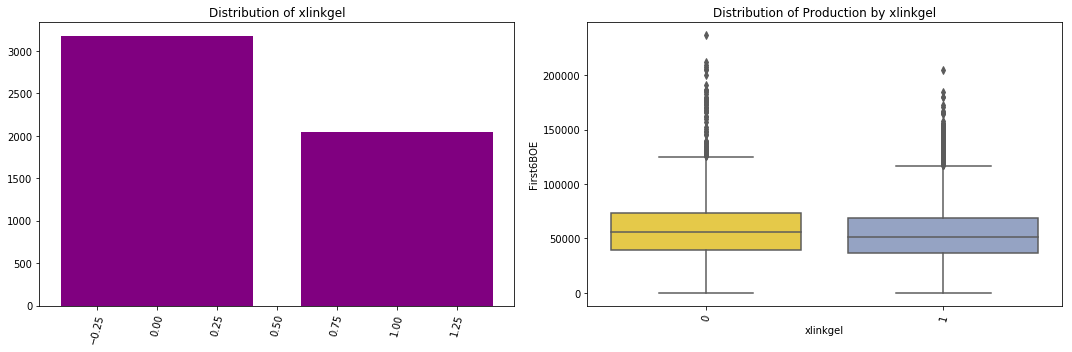

hybrid


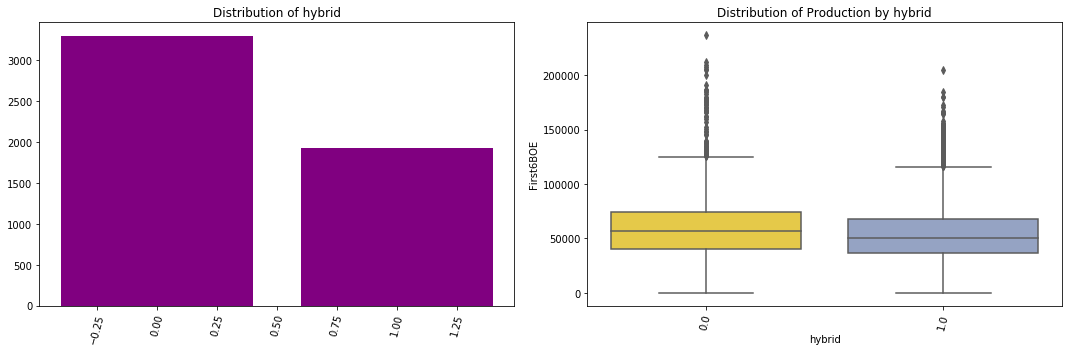

In [14]:
# Creating plots for each column except First 6 BOE
for col in cofrac_red.columns.drop('First6BOE'):
    print(col)
    if col in cofrac_red.select_dtypes(include='object').columns or col in ['gel','slick','xlinkgel','hybrid', 'location', 'County']:
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        temp = cofrac_red[[col, 'First6BOE']]
        temp = temp.dropna()
        plt.bar(temp[col].unique(), height=temp[col].value_counts(), color='Purple')
        plt.xticks(rotation=75)
        plt.title('Distribution of {}'.format(col))
    
        # Plotting distributions of each column by first 6 months production
        plt.subplot(122)
        g = sns.boxplot(y='First6BOE', x=col, data=temp, palette='Set2_r')
        plt.xticks(rotation=75)
        plt.title('Distribution of Production by {}'.format(col))
    
        plt.tight_layout()
        plt.show()
    elif col in cofrac_red.select_dtypes(include=['int64','float64']).columns.drop(['gel','slick','xlinkgel','hybrid']):
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(cofrac_red[col].dropna(axis=0), color='Purple')
        plt.title('Distribution of {}'.format(col))
        
        # Plotting scatter plot of each column by production
        plt.subplot(122)
        #temp = cofrac_red[[col, 'First6BOE']]
        #temp = temp.dropna()
        sns.regplot(x=cofrac_red[col], y=cofrac_red['First6BOE'], color='Blue')
        plt.title('First 6 Months of Production vs {}'.format(col))
        
        plt.tight_layout()
        plt.show()
    
        

Insights from these visualizations:
- The __location__ clusters are fairly evenly spread, with spikes in location 0 and location 2, however the distributions of production looks like the clustered locations were able to identify some of the more and less productive areas. The following are the analyses of the variables clustered in the location labels:
    - Most of the wells are located in Adam's county, but Weld county has the highest production levels.  
    - The Wattenberg field looks like it is the most productive
    - Niobrara and Codell formations look equally productive, and all other formations less productive
    - Township and ranges are spread all over the place, with only about 10 township and ranges that have low production. 
    - I will be able to __drop all of the location-based features in lieu of the location cluster labels__
- __Gross perforated interval__ has a trimodal distribution, with peaks between 2500-5000, 5000-8000, and 8000-11000.  While the regplot looks like there is a positive correlation between increased perforation intervals, and production, I think this variable might be better __binned into three groups__.
- __Horizontal length__ also has a trimodal distribution, with peaks between 2500-6000, 6000-9000, and 9000-12000 ft. These are typically 1 mile, 1.5 mile, or 2 mile targets.  I will also __put these lengths into three groups__, accordingly.
- __Lower perforation__ is non-normally distributed, so I will need to __identify some transformations to normalize this variable__, but again, it appears that the deeper the lower perforation, the larger the production.
- __Total depth__ appears it could be a bimodal or trimodal distribution, but this is not as clearly delineated.  I again will need to __identify some transformations to normalize this variable__.  I also might want to consider combining some of the depth variables into one.
- __Treatment job count__ is mostly centered at 1, and doesn't appear to have any correlation to production.  I will check the p-value on this, but I will likely __drop treatment job count__ from the data set.
- __Upper perforation__ looks approximately normally distributed, with a slight hump to the left.  I want to see what the __difference between upper and lower perforations__ would look like against the production.
- __Vertical depth__ also has a slight hump to the left at shallower depths, and the production increases slightly with increased depth.  This could be because of its traversal into better formations too, so that's something to look out for in terms of independence.
- The __linear gel__ method of fracing is not used very often, and not using linear gel appears to have a slightly higher distribution of production.  I will need to check the p-value on this distribution.
- __Sand mass__ has a significant outlier at 1.7x10^8 lbs of sand, and the distribution looks like it's slightly skewed to the right even without that.  I will need to normalize this distribution and investigate that large sand use well.
- The __slickwater__ method of fracing is used in the majority of frac jobs and the production distribution looks very higher when using slickwater.  Again, I will need to check the p-value.
- The __cross-linked gel__ method of fracing is again used more than not, and it appears that not cross-linking could be correlated to higher production.  I will check the p-value.
- Wells that use a __hybrid__ method of fracing are slightly less productive than those that do not use a hybrid method.

Now, I want to determine if the different variables have a significant impact on the first six month's production.  Because the distribution of production is non-parametric, I will use the Mann-Whitney U test for the two-value comparisons, the Krustal-Wallis H-test for the variables with three value comparisons, and then the Spearman rank-order correlation coefficient for continuous variables. If the p-values for each of these tests are less than 0.05, then I can reject the null hypothesis that the variables have the same distribution.

In [15]:
# Initializing data frame for p-values from comparison tests
p_vals = pd.DataFrame(columns=['Attribute', 'p_value'])

for col in cofrac_red.columns:
    if col in ['gel','slick','xlinkgel', 'hybrid']:
        # Calculate Mann-Whitney U test for two-value comparisons
        t, p = mannwhitneyu(cofrac_red[cofrac_red[col]==0]['First6BOE'], 
                            cofrac_red[cofrac_red[col]==1]['First6BOE'])
    
    elif col == 'TargetFormation':
        # Calculate Kruskal-Wallis H-test for three comparisons
        t, p = kruskal(cofrac_red[cofrac_red[col]=='NIOBRARA']['First6BOE'], 
                       cofrac_red[cofrac_red[col]=='CODELL']['First6BOE'],
                      cofrac_red[cofrac_red[col]=='OTHER']['First6BOE'])
    
    elif col in cofrac_red.select_dtypes(include=['int64','float64']).columns.drop(['First6BOE','gel','slick','xlinkgel', 'hybrid']):
        # Create temporary data frame to drop null values
        temp = cofrac_red[[col, 'First6BOE']].dropna()
        # Calculate Spearman rank-order correlation coefficient for continuous variables
        rho, p = spearmanr(temp[col], temp['First6BOE'])
    
    # Append the p-values and attributes to a data frame
    p_vals = p_vals.append({'Attribute':col, 'p_value':float(p)}, ignore_index=True)

# Sort and print the p-values 
p_vals.sort_values('p_value')

,Attribute,p_value
8,TotalDepth,0.000000e+00
6,LowerPerforation,4.246528e-290
4,GrossPerforatedInterval,3.309099e-273
5,HorizontalLength,8.519498e-244
14,sandmass,6.388584e-72
12,VerticalDepth,1.265438e-50
0,First6BOE,4.091792e-43
2,location,4.091792e-43
1,County,4.091792e-43
3,Field,4.091792e-43


Based on these comparison tests, I can reject the null hypothesis for all variables except for that of the Township and Range, and the Treatment Job Count, as expected.  The other variables have significant p-values, meaning that we can reject the null hypothesis and state that the variable causes a significant difference between the distributions.

I will, however keep the location cluster labels in lieu of the location-based features to keep that information in a more streamlined feature.

In [16]:
# Dropping location-based features and treatment job count
cofracw = cofrac_red.drop(['TR', 'County', 'Field', 'TargetFormation', 'TreatmentJobCount'], axis=1)

#### Sand Mass and Vertical Depth
Because neither of those variables had very normally distributed values, I will attempt to transform them to become more normally distributed. 

In [17]:
cofracw.sandmass.describe()

count    5.218000e+03
mean     3.787006e+06
std      4.267373e+06
min      0.000000e+00
25%      1.826881e+06
50%      3.163582e+06
75%      4.548139e+06
max      1.681255e+08
Name: sandmass, dtype: float64

sandmass


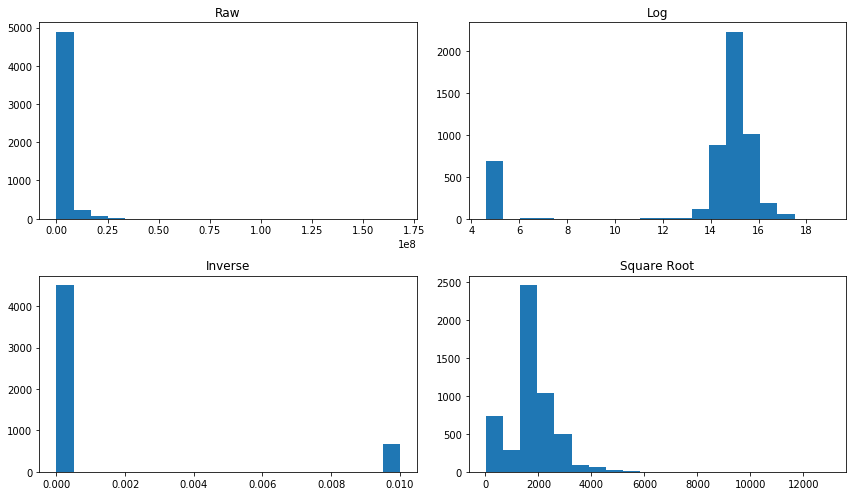

VerticalDepth


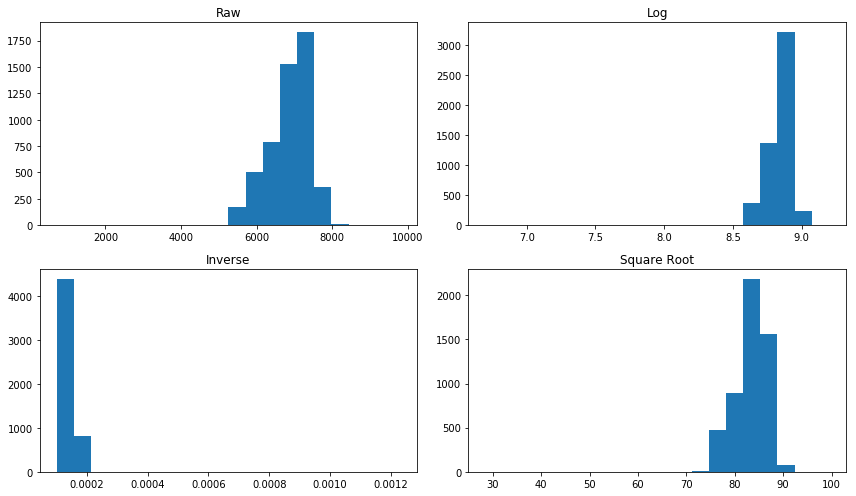

In [18]:
# Transformation to deal with non-normality
for var in ['sandmass','VerticalDepth']:
    print(var)
    plt.figure(figsize=[12,7])
    plt.subplot(221)
    plt.hist(cofracw[var].dropna(), bins=20)
    plt.title('Raw')

    plt.subplot(222)
    plt.hist(np.log(cofracw[var].dropna()+100), bins=20)
    plt.title('Log')

    plt.subplot(223)
    plt.hist(1/(cofracw[var].dropna()+100), bins=20)
    plt.title('Inverse')

    plt.subplot(224)
    plt.hist(np.sqrt(cofracw[var].dropna()+100), bins=20)
    plt.title('Square Root')

    plt.tight_layout()
    plt.show()

The __square root of sand mass__ looks most normally distributed, and after looking into the outliers, those are accurate data points, meaning some operators actually used that much sand.

The __raw vertical depth__ distribution actually looks most normal, so I will continue with that. 

After investigating the source data for the extreme outlier for sand mass, it is a true value of the amount of sand used in a well, but I want to see what the distribution would look like without it on the plot, and without a sand mass of zero because all frac jobs use sand.  I also want to see what the linear and quadratic regression lines would look like, as well as the sand per linear foot.

In [19]:
# Calculating sand per foot
cofracw['sandperft'] = cofracw['sandmass']/cofracw['TotalDepth']
cofracw[cofracw.sandmass < 0.5e8].sandperft.describe()

count    5209.000000
mean      281.163911
std       243.121495
min         0.000000
25%       141.001099
50%       269.750604
75%       354.275123
max      3495.954088
Name: sandperft, dtype: float64

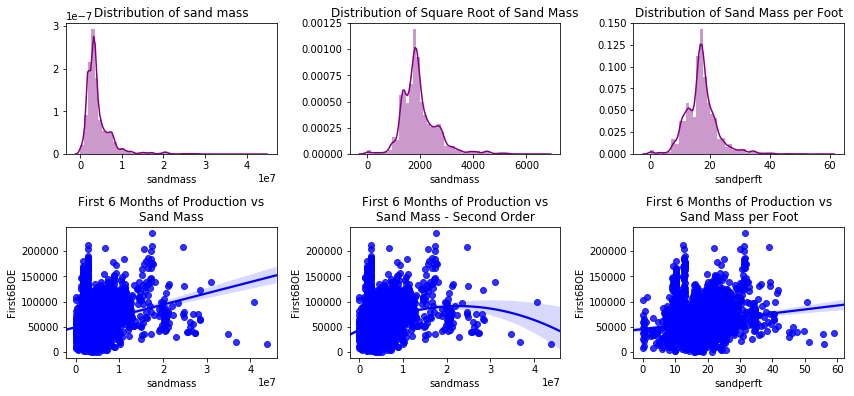

Linear R-squared: 0.07213160443350088
Linear p-value 1.2533232812442068e-75
Quadratic R-squared: 0.07252594769431134
Quadratic p-value 4.778476327681648e-76
Sandperft R-squared: 0.024689171915889284
Sandperft p-value 2.0689975329780616e-26


In [20]:
# Plotting distribution of sand mass
plt.figure(figsize=(12,8))
plt.subplot(331)
# Selecting relevant columns and eliminiating outliers
temp = cofracw[['sandmass', 'First6BOE', 'sandperft']].dropna(axis=0)
temp = temp[temp['sandmass'] < 0.5e8][temp['sandmass'] > 0]
sns.distplot(temp.sandmass, color='Purple')
plt.title('Distribution of sand mass')

plt.subplot(332)
sns.distplot(np.sqrt(temp.sandmass.dropna(axis=0)), color='Purple')
plt.title('Distribution of Square Root of Sand Mass')

plt.subplot(333)
sns.distplot(np.sqrt(temp.sandperft), color='Purple')
plt.title('Distribution of Sand Mass per Foot')

# Plotting scatter plot of sand mass by production
plt.subplot(334)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs\nSand Mass')

plt.subplot(335)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=2)
plt.title('First 6 Months of Production vs\nSand Mass - Second Order')

plt.subplot(336)
sns.regplot(x=np.sqrt(temp.sandperft), y=temp.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs\nSand Mass per Foot')

plt.tight_layout()
plt.show()

# Calculating the R-squared values for each variable
m, b, r, p, se = linregress(temp.sandmass, temp.First6BOE)
print('Linear R-squared:', r**2)
print('Linear p-value', p)

m, b, r, p, se = linregress(np.sqrt(temp.sandmass), temp.First6BOE)
print('Quadratic R-squared:', r**2)
print('Quadratic p-value', p)

m, b, r, p, se = linregress(temp.sandperft, temp.First6BOE)
print('Sandperft R-squared:', r**2)
print('Sandperft p-value', p)

The sand per linear foot transformation definitely looks most normal, but the R-squared for the regression is fairly low, so I will definitely keep the sand per linear foot and square root of sand mass as a feature. I will also drop the extreme outlier of sand mass and the zero-values of sand.

In [21]:
# Creating square root of sand mass feature
cofracw['sqrtsandmass'] = np.sqrt(cofracw['sandmass'])
# Eliminating extreme sand mass outlier
cofracw = cofracw[cofracw.sandmass < 0.5e8][cofracw.sandmass > 0]

### Independence between Variables
Next, I want to check out the independence between the various variables to determine the overlap of information.

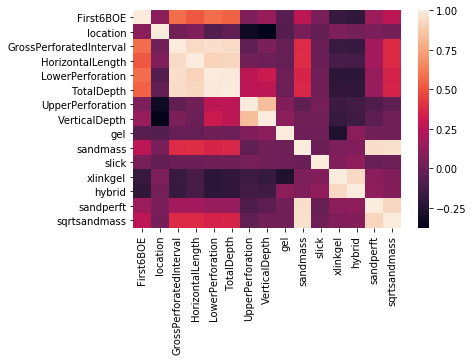

In [22]:
corrmat = cofracw.corr()
sns.heatmap(corrmat)
plt.show()

Because the gross perforated interval, horizontal length, lower perforation and total depth are all highly correlated with one another, I will need to decide which variables to keep and/or engineer and which to remove.  

Current rationale:
- Total depth represents the horizontal length plus the vertical depth, both of which are important decision points for well operators.  For this reason, I will __drop total depth__.
- Upper and Lower Perforations, along with the gross perforated interval all, in theory, should be related to one another. I want to see if I can __engineer the non-perforated horizontal length ( $HorizontalLength - GrossPerforatedInterval$ )__ to get more information from those, without having to drop too much information.  I will also __drop upper and lower perforations__.
- Knowing the data, I will also have to __impute some of the gross perforated intervals__, so I will see how those compare to horizontal length to possibly impute from that.

In [23]:
# Dropping total depth, lower and upper perforations
cofracw = cofracw.drop(['TotalDepth', 'LowerPerforation', 'UpperPerforation'], axis=1)
cofracw = cofracw.dropna(subset=['VerticalDepth'], axis=0)

### Horizontal Length and Grosss Perforated Interval
Now because gross perforated interval and horizontal length were highly correlated, I want to check the relationship between the two to see if these are linearly related so I can potentially use that relationship to impute the missing gross perforated interval values. 

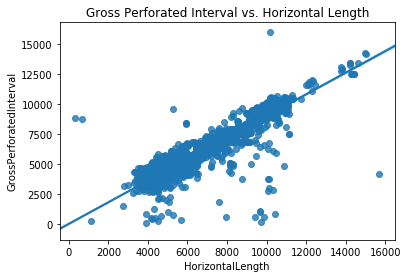

Slope: 0.9628966049370298
Intercept: 793.1997205677235
R-squared: 0.8680938817354695


In [24]:
# Graphing Gross perforated interval versus horizontal length
temp = cofrac[['GrossPerforatedInterval', 'HorizontalLength']].dropna()
sns.regplot(y=temp.GrossPerforatedInterval, x=temp.HorizontalLength)
plt.title('Gross Perforated Interval vs. Horizontal Length')
plt.show()

m, b, r, p, se = linregress(temp.GrossPerforatedInterval, temp.HorizontalLength)
print('Slope: {}\nIntercept: {}\nR-squared: {}'.format(m,b, r**2))

Based on this analysis, the gross perforated interval is 0.97 times as large as the horizontal length.  This is a pretty tight correlation because the R-squared value is 0.94 and the p-value is 0.0.  For this reason, I will impute missing gross perforated intervals by multiplying 0.97 times the horizontal length.  I also want to check out the horizontal lengths that are nearly zero to see if they were errors on entry or what happened in those situations. 

In [25]:
# Identifying all wells with less than 2000 ft of horizontal distance
cofracw[cofracw['HorizontalLength']<2000]

,First6BOE,location,GrossPerforatedInterval,HorizontalLength,VerticalDepth,gel,sandmass,slick,xlinkgel,hybrid,sandperft,sqrtsandmass
APINumber,,,,,,,,,,,,
5005071790000,12229.0,0,NaN,43.67,7999.00,0,5.026834e+02,1,1,1.0,0.062835,22.420602
5005072170000,102079.0,0,NaN,504.14,7880.00,0,7.276202e+06,1,1,1.0,913.980910,2697.443610
5123334110000,22612.0,3,NaN,1468.71,6206.14,0,1.885194e+06,1,1,1.0,234.798051,1373.023506
5123344050000,49006.0,13,NaN,1578.40,5702.00,0,2.902415e+06,1,1,1.0,405.818602,1703.647451
5123352140000,21574.0,1,NaN,449.48,6822.48,0,3.436077e+06,1,1,1.0,483.818159,1853.665709
5123353220000,10423.0,1,NaN,1065.08,6639.53,0,1.455836e+06,1,1,1.0,197.481832,1206.580318
5123357450000,33934.0,1,NaN,1140.65,6334.10,0,1.834557e+06,1,1,1.0,279.147519,1354.458377
5123359820000,58316.0,2,NaN,353.40,7282.87,0,3.083189e+06,1,1,1.0,410.325869,1755.901073
5123362450000,85233.0,7,NaN,455.20,6786.77,0,5.054498e+06,1,1,1.0,739.394152,2248.221169


Inconsistencies I see between COGIS database and this data...and more.
- 5123417840000 VD should be 6394. Horizontal length should be 9550
- 5123417870000 VD should be 6449.  Horizontal length should be 9578
- 5123334110000 Hz Length should be 4262 and GPI should be 3767

Knowing that a horizontal length of less than 2000 is unrealistic for a horizontal well, and after checking some of these entries, it appears that the data in the data frame does not match that in the original database.  Some of these wells had separate completions, which have apparently  gotten lost in the data extraction.  Because these encompass less than 1% of the data, I will drop these wells from our analysis.

In [26]:
todrop = cofracw[cofracw['HorizontalLength']<2000].index
cofracw = cofracw.drop(todrop, axis=0)

Great, now I want to impute gross perforated intervals for missing data before engineering another variable using those values.  The equation I will use comes from the linear relationship between gross perforated interval and horizontal length, which is: $ GPI = HZlength * 0.9743 + 711.3 $

In [27]:
# Calculating predicted values for Gross Perforated Interval
cofracw['GPIpred'] = cofracw.HorizontalLength*0.9742595569413872 + 711.3033745388957

# Filling all NAs with 0 for imputing
cofracw2 = cofracw.fillna(0)

# Imputing
for idx in cofracw2.index:
    if cofracw2.GrossPerforatedInterval[idx] > 0:
        pass
    else:
        cofracw2.GrossPerforatedInterval[idx] = cofracw2['GPIpred'][idx]

#### Feature Engineering - Non-perforated Horizontal Feet
Knowing that there is a relationship between horizontal feet and gross perforation interval, I want to capture the information that is in the difference between the two values.  To capture this, I will calculate the non-perforated feet. 

In [28]:
# Calculating non-perforated horizontal feet
nonperfhzft = cofracw2.HorizontalLength - cofracw2.GrossPerforatedInterval

# Comparison testing between distributions of non-perforated feet and production 
spearmanr(nonperfhzft, cofracw2['First6BOE'])

SpearmanrResult(correlation=0.06176559658553038, pvalue=3.367251368764284e-05)

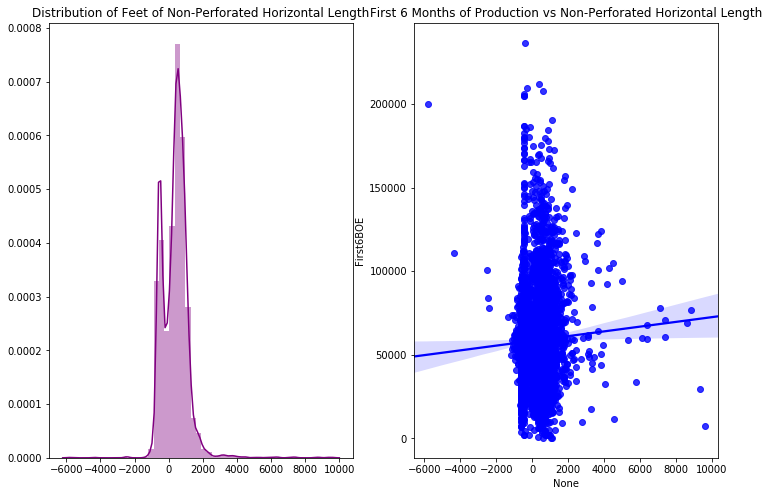

count    4502.000000
mean      376.948900
std       776.398588
min     -5800.430000
25%      -165.502500
50%       435.985000
75%       780.047500
max      9589.510000
dtype: float64

In [29]:
# Graphing Distrubtion of non-perforated feet and its relationship to production
plt.figure(figsize=(12,8))
plt.subplot(121) 
sns.distplot(nonperfhzft, color='Purple')
plt.title('Distribution of Feet of Non-Perforated Horizontal Length')

plt.subplot(122)
sns.regplot(x=nonperfhzft, y=cofracw2.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs Non-Perforated Horizontal Length')
plt.show()
nonperfhzft.describe()

This looks like the non-perforated feet is a bimodal distribution, with the split at zero.  Gross perforated feet over horizontal length means that the operator fraced the vertical section of the well in addition to the horizontal section, whereas a positive value of non-perforated horizontal feet means that the operator only fraced a portion of the horizontal length.  Because of this bimodal distribution, I will try some transformations to create a more normal distribution, but I also might try to binarize this variable into only-horizontal frac versus horizontal and vertical fracing.

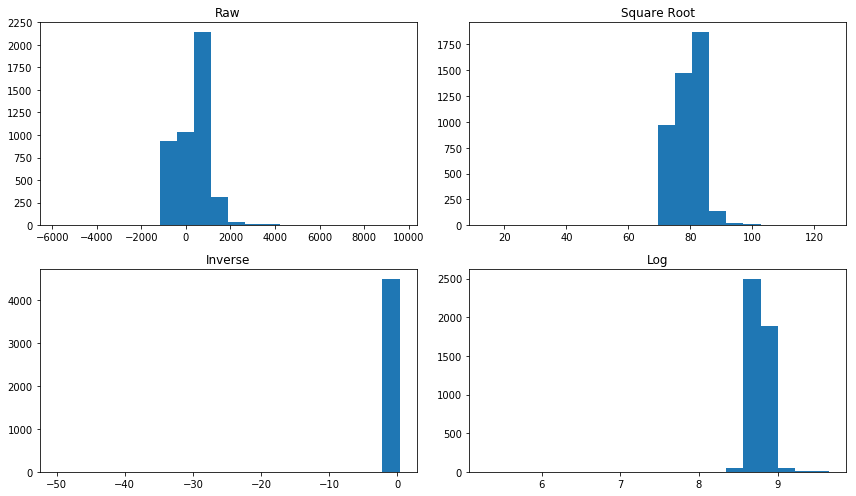

In [30]:
# Transformations for non-normality
plt.figure(figsize=[12,7])
plt.subplot(221)
plt.hist(nonperfhzft, bins=20)
plt.title('Raw')

plt.subplot(222)
plt.hist(np.sqrt(nonperfhzft+6000), bins=20)
plt.title('Square Root')

plt.subplot(223)
plt.hist(1/nonperfhzft, bins=20)
plt.title('Inverse')

plt.subplot(224)
plt.hist(np.log(nonperfhzft+6000), bins=20)
plt.title('Log')

plt.tight_layout()
plt.show()

The square root transformation looks most normal, but I had to add a value of 6000 to make all of the values positive to take the square root.  I want to binarize the distribution and see how the two different transformations are related to production.

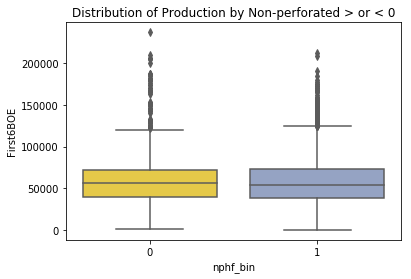

Binary Mann-Whitney U: MannwhitneyuResult(statistic=2076706.0, pvalue=0.3975131761755937)


In [31]:
# Binarizing non-perforated horizontal feet
cofracw2['nphf_bin'] = nonperfhzft.map(lambda x: 0 if x <=0 else 1)

# Plotting distribtion of binary feature
sns.boxplot(y='First6BOE', x='nphf_bin', data=cofracw2, palette='Set2_r')
plt.title('Distribution of Production by Non-perforated > or < 0')
plt.show()

print('Binary Mann-Whitney U: {}'.format(mannwhitneyu(cofracw2[cofracw2.nphf_bin==0]['First6BOE'], 
                                                                         cofracw2[cofracw2.nphf_bin==1]['First6BOE'])))

In [32]:
# Comparison testing between distributions of non-perforated feet and production 
spearmanr(np.sqrt(nonperfhzft+6000), cofracw2['First6BOE'])

SpearmanrResult(correlation=0.0617652492112652, pvalue=3.3675949325775486e-05)

Well, according to the p-values for the distributions, I should not keep the binary version of non-perforated feet, but I should keep the square root version.  Because of the need to turn this into a positive value, this essentially becomes non-perforated feet. 

In [33]:
cofracw2['nphf_sqrt'] = np.sqrt(nonperfhzft+6000)

#### Feature Engineering - Binned Horizontal Length
As mentioned earlier, I will bin the horizontal feet to eliminate the trimodal distribution.

In [34]:
# Creating bins for the three general horizontal legnths
bins = [0,6500,8500,250000]
cofracw2['hzlen_bin'] = pd.cut(cofracw2['HorizontalLength'], bins,
                              labels = ['<1', '1-2', '>2'])

Now, let's check for the distribution of wells in these bins.

In [35]:
cofracw2.hzlen_bin.value_counts()

<1     2865
>2      900
1-2     737
Name: hzlen_bin, dtype: int64

Wells mostly fall within one mile of vertical, but a good number are around two miles, and a slightly smaller number are between one and two miles in horizontal length.

Now, I want to check to see how the bins are related to production in the first six months after fracing.

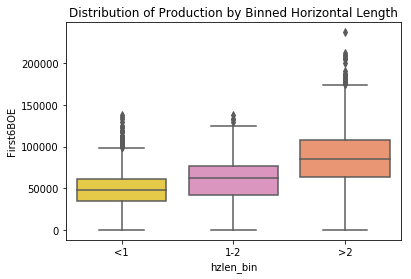

In [36]:
# Plotting distribtion of binary feature
sns.boxplot(y='First6BOE', x='hzlen_bin', data=cofracw2, palette='Set2_r')
plt.title('Distribution of Production by Binned Horizontal Length')
plt.show()

Wow, this definitely looks like the longer the horizontal length, the greater the production.  I will check this difference through the Kruskal test for the three distributions. If the p-value of this test is significant at an alpha of 0.05, then there is a difference in the distributions.

In [37]:
print('Binned Kruskal: {}'.format(kruskal(cofracw2[cofracw2.hzlen_bin=='<1']['First6BOE'], 
                                            cofracw2[cofracw2.hzlen_bin=='1-2']['First6BOE'],
                                         cofracw2[cofracw2.hzlen_bin=='>2']['First6BOE'])))

Binned Kruskal: KruskalResult(statistic=956.9809786019097, pvalue=1.563942758152597e-208)


Based on the p-value from the Kruskal test, there is a significant difference between the production of the bins.  This does not give us information about which are different, so I will calculate the Mann Whitney U test for each pair.

In [38]:
print('<1 vs 1-2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE']))
print('<1 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))
print('1-2 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))

<1 vs 1-2 MannwhitneyuResult(statistic=746405.0, pvalue=5.389325106596935e-35)
<1 vs >2 MannwhitneyuResult(statistic=437760.5, pvalue=3.6946877340667905e-197)
1-2 vs >2 MannwhitneyuResult(statistic=183059.5, pvalue=2.8349558877896165e-55)


Based on the Mann Whitney U Test, all of the bins of horizontal length have significant differences in production.  I will definitely keep this as a feature in our modeling.

### Gathering Features for Modeling
Based on the above analysis, the following are features that I will use to predict the production from the first six months of the well:
- Types of Fracing: Gel, Slickwater and Cross-linked Gel
- Drilling Characteristics: Target Formation, Vertical Depth, Horizontal Length (binned), and Non-perforated length (square root)
- Frac Characteristic: Sand mass (square root)


In [44]:
# Selecting out relevant features for modeling
cofeatures = cofracw2[['gel','slick','xlinkgel','hybrid',
                       'VerticalDepth', 'HorizontalLength','hzlen_bin',
                       'GrossPerforatedInterval', 'nphf_sqrt',
                       'sandmass', 'sqrtsandmass','sandperft',
                       'location',
                        'First6BOE']]
cofeatures.head()

,gel,slick,xlinkgel,hybrid,VerticalDepth,HorizontalLength,hzlen_bin,GrossPerforatedInterval,nphf_sqrt,sandmass,sqrtsandmass,sandperft,location,First6BOE
APINumber,,,,,,,,,,,,,,
5001098010000,0,1,1,1.0,7774.00,2247.84,<1,2901.282977,73.120155,2.533881e+06,1591.816874,249.373188,2,46241.0
5001097850000,0,1,1,1.0,7576.73,4499.09,<1,5094.584805,73.515340,3.274332e+06,1809.511658,268.887993,0,7094.0
5001097830000,0,1,1,1.0,7511.68,4556.06,<1,5150.088372,73.525313,3.045143e+06,1745.033863,250.320443,0,8304.0
5001097820000,0,1,1,1.0,7574.72,4525.40,<1,5120.217574,73.519946,2.784211e+06,1668.595385,228.313165,1,7118.0
5001097810000,0,1,1,1.0,7513.70,4504.51,<1,5099.865291,73.516289,3.056162e+06,1748.188233,252.211029,0,10385.0


Now, just a final check that our features are independent, let's check out the heatmap for the features.

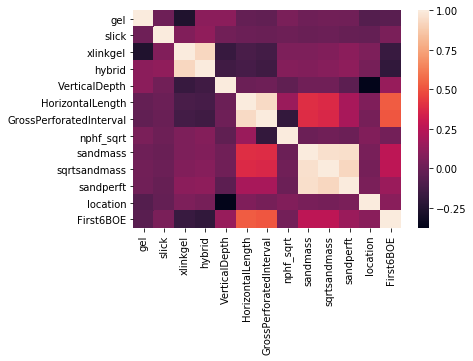

In [45]:
corrmat = cofeatures.corr()
sns.heatmap(corrmat)
plt.show()

Great, looks like the features are all independent from each other.  Finally, to prepare for modeling, I will get dummy variables for the target formations and horizontal lengths

In [46]:
cofeatures = pd.get_dummies(cofeatures)
cofeatures.head()

,gel,slick,xlinkgel,hybrid,VerticalDepth,HorizontalLength,GrossPerforatedInterval,nphf_sqrt,sandmass,sqrtsandmass,sandperft,location,First6BOE,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,,,,,,
5001098010000,0,1,1,1.0,7774.00,2247.84,2901.282977,73.120155,2.533881e+06,1591.816874,249.373188,2,46241.0,1,0,0
5001097850000,0,1,1,1.0,7576.73,4499.09,5094.584805,73.515340,3.274332e+06,1809.511658,268.887993,0,7094.0,1,0,0
5001097830000,0,1,1,1.0,7511.68,4556.06,5150.088372,73.525313,3.045143e+06,1745.033863,250.320443,0,8304.0,1,0,0
5001097820000,0,1,1,1.0,7574.72,4525.40,5120.217574,73.519946,2.784211e+06,1668.595385,228.313165,1,7118.0,1,0,0
5001097810000,0,1,1,1.0,7513.70,4504.51,5099.865291,73.516289,3.056162e+06,1748.188233,252.211029,0,10385.0,1,0,0


These look great. 

Writing features to csv for modeling.

In [47]:
cofeatures.to_csv('cofeatures.csv', index_label='APINumber')

Potential code for adding altitude as a feature

In [ ]:
#from json import loads
#from time import sleep
#from urllib2 import Request, urlopen

#locations=[(27.988056, 86.925278), (50.449561, 30.525366)] #(lat,lon) pairs
#for loc in locations: 
#    try:
#        request = Request('https://maps.googleapis.com/maps/api/elevation/json?locations={0},{1}&key=INSERT_YOUR_KEY_HERE'.format(loc[0],loc[1]))
#        response = urlopen(request).read() 
#        places = loads(response)
#        print 'At {0} elevation is: {1}'.format(loc, places['results'][0]['elevation'])
#        sleep(1)
#    except:
#        print 'Error for location: {0}'.format(loc)